# Import Modules

In [11]:
from data.echogram import DataReaderZarr, get_data_readers
from batch.samplers.school_seabed import SchoolSeabedZarr
from batch.samplers.background_seabed import BackgroundSeabedZarr
from batch.samplers.school import SchoolZarr
from batch.samplers.seabed import SeabedZarr
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing
from scipy import stats as st
from pandas.plotting import scatter_matrix
import xarray as xr
import seaborn as sns

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Modified Objects

In [12]:
class P_refine_label_boundary():
    def __init__(self,
                 frequencies=[18, 38, 120, 200],
                 threshold_freq=200,
                 threshold_val=[1e-7, 1e-4],
                 ignore_val=-100,
                 ignore_zero_inside_bbox=True
                 ):
        self.frequencies = frequencies
        self.threshold_freq = threshold_freq
        self.threshold_val = threshold_val
        self.ignore_val = ignore_val
        self.ignore_zero_inside_bbox=ignore_zero_inside_bbox

    def __call__(self, data, labels, echogram):
        '''
        Refine existing labels based on thresholding with respect to pixel values in image.
        :param data: (numpy.array) Image (C, H, W)
        :param labels: (numpy.array) Labels corresponding to image (H, W)
        :param echogram: (Echogram object) Echogram
        :param threshold_freq: (int) Image frequency channel that is used for thresholding
        :param threshold_val: (float) Threshold value that is applied to image for assigning new labels
        :param ignore_val: (int) Ignore value (specific label value) instructs loss function not to compute gradients for these pixels
        :param ignore_zero_inside_bbox: (bool) labels==1 that is relabeled to 0 are set to ignore_value if True, 0 if False
        :return: data, new_labels, echogram
        '''

        closing = np.array([
            [0, 0, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 0, 0]
        ])

        if self.ignore_val == None:
            self.ignore_val = 0

        # Set new label for all pixels inside bounding box that are below threshold value
        if self.ignore_zero_inside_bbox:
            label_below_threshold = self.ignore_val
        else:
            label_below_threshold = 0

        # Get refined label masks
        freq_idx = self.frequencies.index(self.threshold_freq)

        # Relabel
        new_labels = labels.copy()

        mask_threshold = (labels != 0) & (labels != self.ignore_val) & (data[freq_idx, :, :] > self.threshold_val[0]) & (
                    data[freq_idx, :, :] < self.threshold_val[1])
        # Padding
        mask_threshold = np.pad(mask_threshold, ((3,3),(3,3)), 'constant')
        
        mask_threshold_closed = binary_closing(mask_threshold, structure=closing)
        
        # Remove Padding
        mask_threshold_closed = mask_threshold_closed[3:-3,3:-3]
        
        mask = (labels != 0) & (labels != self.ignore_val) & (mask_threshold_closed == 0)

        new_labels[mask] = label_below_threshold
        new_labels[labels == self.ignore_val] = self.ignore_val

        return data, new_labels, echogram
    
def xr_db_with_limits(xarr, limit_low=-75, limit_high=0): # Function to be applied to xarray dataarray
    data = db(xarr)
    result = data.where((data<limit_high) | (data.isnull()), limit_high)
    result = result.where((result>limit_low) | (result.isnull()), limit_low)
    return result

def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

In [14]:
# Modified Background Sampler for y axis - Patches are selected within the water column only, no exceed
# Near field (first 20 rows) are also excluded. the interval = [20, (seabed - 128)]
class BackgroundZarr():
    def __init__(self, zarr_files, window_size=(256, 256)):
        """
        Sample from zarr-files
        :param zarr_files: (list)
        :param window_size: (tuple)
        """
        self.zarr_files = zarr_files
        self.window_size = window_size

    def get_sample(self):
        # Select random zarr file in list
        zarr_rand = np.random.choice(self.zarr_files)

        # select random ping in zarr file
        x = np.random.randint(self.window_size[1] // 2, zarr_rand.shape[0] - self.window_size[1] // 2)

        # Get y-loc above seabed
        seabed = int(zarr_rand.get_seabed(x))


        if seabed - (self.window_size[0]+20) <= 0:
            return self.get_sample()
        y = np.random.randint(self.window_size[0]//2 + 20, seabed-self.window_size[0]//2)


        # Check if any fish_labels in the crop
        labels = zarr_rand.get_label_slice(idx_ping=x-self.window_size[1]//2,
                                           n_pings=self.window_size[1],
                                           idx_range=max(0, y-self.window_size[0]//2),
                                           n_range=self.window_size[0],
                                           drop_na=False,
                                           return_numpy=False)

        # Check if any fish-labels in crop
        if (labels > 0).any() or (labels == -1).all(): # Possible bottleneck?
            return self.get_sample()

        return [x, y], zarr_rand

# Creating Coordinates

In [56]:
survey = [readers[0]]
window_size = [256, 256]
samplers = [BackgroundZarr(survey, window_size),
            SeabedZarr(survey, window_size),
            SchoolZarr(survey, window_size, 27),
            SchoolZarr(survey,  window_size, 1),
            SchoolSeabedZarr(survey, window_size, max_dist_to_seabed=window_size[0]//2, fish_type=27),
            SchoolSeabedZarr(survey, window_size, max_dist_to_seabed=window_size[0]//2, fish_type=1)]
sampl = 500
crdinates = np.zeros((sampl*len(samplers),3)) 

for i, sampler in tqdm(enumerate(samplers), total=len(samplers), desc='Samplers..'):
    for n in range(sampl):
            crdinates[sampl*i+n,0] = i
            crdinates[sampl*i+n,(1,2)] = sampler.get_sample()[0]

crdinates = crdinates.astype('int')
#for i in tqdm(range(len(crdinates)), total=len(crdinates)):
#    crdinates[i, :] = BackgroundZarr(survey).get_sample()[0]

Samplers..: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [19:01<00:00, 190.24s/it]


In [ ]:
coordinates = crdinates[crdinates[:,2]>127]
coordinates

In [ ]:
cordinates_bg_rand = coordinates[:,1:]
cordinates_bg_rand

# Extracting Patch Information

In [80]:
# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(cordinates_bg_rand), 53))  ## UPDATE EDILECEK
quantiles = [0, 0.25, 0.5, 0.75, 0.95, 1]
survey = readers[0]

for i, (x, y) in tqdm(enumerate(cordinates_bg_rand), total=len(cordinates_bg_rand)):
    # Data Loading & Preparations
    org_sv = survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                   idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                   return_numpy=False, frequencies=[38000, 200000])
    data_Sv = xr_db_with_limits(org_sv)
    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                         idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                         return_numpy=False)
    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]
    y_label = survey.get_label_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                     idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                     return_numpy=True)
    modified = P_refine_label_boundary(ignore_zero_inside_bbox=False,
                                       threshold_val=[1e-07, 1e-04], frequencies=[38, 200])(data=org_sv.values,
                                                                                            labels=y_label,
                                                                                            echogram=org_sv.values)
    modified = modified[1]  # Final 2D modified annotations
    np_Sv = data_Sv.sel(frequency=38000).values  # Sv data slice in 38 kHz frequency

    # Coordinates
    data[i, 0] = x
    data[i, 1] = y

    # Patch Statistics
    data[i, 2] = mean_Sv = np.nanmean(np_Sv)  # mean (excluding nan)
    data[i, 3] = mode_Sv = st.mode(np_Sv.flatten())[0]  # mode (excluding nan)
    data[i, 4] = np.nanstd(np_Sv)  # standard deviation (excluding nan)
    data[i, 5], data[i, 6], data[i, 7], data[i, 8], data[i, 9], data[i, 10] = np.nanquantile(np_Sv, q=quantiles)

    # Number of Pixels
    data[i, 11] = seabed_mask.sum().values  # Pixels below seabed
    data[i, 12] = len(modified[modified == 1])  # Other class
    data[i, 13] = len(modified[modified == 27])  # Sandeel class
    data[i, 14] = len(modified[modified == 6009])  # Possible Sandeel class
    data[i, 15] = np.isnan(np_Sv).sum()  # Number of nan pixels
    data[i, 16] = 256 * 256 - (
                data[i, 12] + data[i, 13] + data[i, 14] + data[i, 15])  # Background class (Excluding nan values)

    # Class Statistics

    # Other Class
    if data[i, 12] != 0:
        ot_filt = np_Sv[modified == 1]
        # Mean, Mode, Std Other Sv
        data[i, 17], data[i, 18], data[i, 19] = ot_filt.mean(), st.mode(ot_filt.flatten())[0], np.std(ot_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 20], data[i, 21], data[i, 22], data[i, 23], data[i, 24], data[i, 25] = np.quantile(ot_filt, q=quantiles)

    # Sandeel Class
    if data[i, 13] != 0:
        sd_filt = np_Sv[modified == 27]
        # Mean, Mode, Std Sandeel Sv
        data[i, 26], data[i, 27], data[i, 28] = sd_filt.mean(), st.mode(sd_filt.flatten())[0], np.std(sd_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 29], data[i, 30], data[i, 31], data[i, 32], data[i, 33], data[i, 34] = np.quantile(sd_filt, q=quantiles)

    # Possible Sandeel Class
    if data[i, 14] != 0:
        ps_filt = np_Sv[modified == 6009]
        # Mean, Mode, Std possible Sandeel Sv
        data[i, 35], data[i, 36], data[i, 37] = ps_filt.mean(), st.mode(ps_filt.flatten())[0], np.std(ps_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 38], data[i, 39], data[i, 40], data[i, 41], data[i, 42], data[i, 43] = np.quantile(sd_filt, q=quantiles)

    # Background
    if data[i, 16] == 256 * 256:
        # If there is no fish, statistics are the same as patch
        data[i, 44], data[i, 45], data[i, 46] = data[i, 2], data[i, 3], data[i, 4]
        data[i, 47], data[i, 48], data[i, 49], data[i, 50], data[i, 51], data[i, 52] = data[i, 20], data[i, 21], data[
            i, 22], data[i, 23], data[i, 24], data[i, 25]
    else:
        bg_flt = np_Sv[np.logical_or((modified == 0), (modified == -1))]
        # Mean, Mode, Std Background Sv
        data[i, 44], data[i, 45], data[i, 46] = np.nanmean(bg_flt), st.mode(bg_flt.flatten(), nan_policy='omit')[
            0], np.nanstd(bg_flt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 47], data[i, 48], data[i, 49], data[i, 50], data[i, 51], data[i, 52] = np.nanquantile(bg_flt,
                                                                                                      q=quantiles)

  1%|█▎                                                                                                                                                                        | 21/2810 [00:27<59:50,  1.29s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_in

# Saving & Loading Data

In [160]:
#data[:,16] = 256 * 256 - (data[:, 12] + data[:, 13] + data[:, 14] + data[:, 15]) # nop_bg correction
#np.savetxt("patch_samplers_all.csv", data, delimiter=",")
BG_Sv_data = np.loadtxt('patch_samplers_all.csv', delimiter=",")

pdata = pd.DataFrame(BG_Sv_data)

names_modified = ['x', 'y', 'mean_Sv', 'mode_Sv', 'std_Sv', 
                  '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv',
                  'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan','nop_background',
                  'mean_other', 'mode_other', 'std_other',
                  '0_Other', '25_Other', '50_Other', '75_Other', '95_Other', '100_Other',
                  'mean_sandeel', 'mode_sandeel', 'std_sandeel',
                  '0_sandeel', '25_sandeel', '50_sandeel', '75_sandeel', '95_sandeel', '100_sandeel',
                  'mean_psandeel', 'mode_psandeel', 'std_psandeel',
                  '0_psandeel', '25_psandeel', '50_psandeel', '75_psandeel', '95_psandeel', '100_psandeel',
                  'mean_bg', 'mode_bg', 'std_bg',
                  '0_bg', '25_bg', '50_bg', '75_bg', '95_bg', '100_bg']
pdata.columns = names_modified
pdata['sampler'] = coordinates[:,0]
samplers_str = ['Background Sampler','Seabed Sampler', 'Sandeel Sampler',
                'Other Sampler', 'Sandeel Seabed Sampler', 'Other Seabed Sampler']
pdata['sampler'] = pdata['sampler'].replace([0,1,2,3,4,5], samplers_str)
print('Number of patches from samplers - Exceeding sea surface ones are excluded')
pdata.sampler.value_counts()

Number of patches from samplers - Exceeding sea surface ones are excluded


Background Sampler        500
Seabed Sampler            490
Other Seabed Sampler      485
Other Sampler             458
Sandeel Seabed Sampler    447
Sandeel Sampler           430
Name: sampler, dtype: int64

# Patch Pixel Summary (almost equal probabilities for each sampler)

In [161]:
ot, sd, bg, sm = pdata.nop_other.sum(), pdata.nop_sandeel.sum(), pdata.nop_background.sum(), (pdata.nop_other.sum()+pdata.nop_sandeel.sum()+pdata.nop_background.sum())
print(f'Other = % {(100*ot/sm):.2f}, Sandeel = % {100*sd/sm:.2f}, Background = % {100*bg/sm:.2f}')

Other = % 0.27, Sandeel = % 0.33, Background = % 99.40


# All Nan Pixels (Because of Bottom errors)

In [229]:
pdata[pdata.nop_nan==256*256].sampler.value_counts()
pdata[pdata.nop_nan==256*256]

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,...,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,sampler
21,2020340.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
24,2021569.0,673.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
40,3533028.0,1413.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
47,2055007.0,1181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
57,2038256.0,1761.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
67,2051946.0,2382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
73,129726.0,963.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
82,2028725.0,1020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
101,2072370.0,2117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler
111,3520665.0,1545.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Background Sampler


# Nop Below Seabed Filter (This should be improved by setting seabed at the surface)

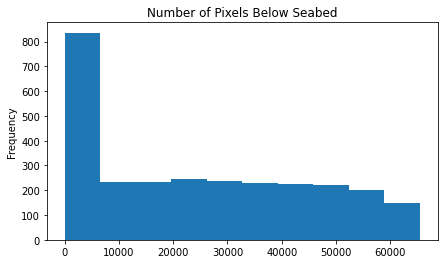

In [183]:
plt.figure(figsize=(7,4))
pdata.nop_below_seabed.plot(kind='hist')
plt.title('Number of Pixels Below Seabed')
plt.show()

# Example Patches (Seabed Sampler can contain fish schools)

In [261]:
print(f'Number of Sandeel pixels in Seabed Sampler = {pdata[pdata.sampler == "Seabed Sampler"].nop_sandeel.sum()}')
print(f'Number of Other pixels in Seabed Sampler = {pdata[pdata.sampler == "Seabed Sampler"].nop_other.sum()}')

pdata.iloc[[800,802],:]

Number of Sandeel pixels in Seabed Sampler = 21846.0
Number of Other pixels in Seabed Sampler = 18319.0


,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,100_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,mean_other,mode_other,std_other,0_Other,25_Other,50_Other,75_Other,95_Other,100_Other,mean_sandeel,mode_sandeel,std_sandeel,0_sandeel,25_sandeel,50_sandeel,75_sandeel,95_sandeel,100_sandeel,mean_psandeel,mode_psandeel,std_psandeel,0_psandeel,25_psandeel,50_psandeel,75_psandeel,95_psandeel,100_psandeel,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,sampler
800,459692.0,310.0,-71.216522,-75.0,12.038620,-75.0,-75.0,-75.0,-75.0,-49.085451,0.0,44958.0,96.0,0.0,0.0,0.0,65440.0,-62.388393,-75.0,7.499699,-75.0,-68.106194,-62.120373,-57.492282,-50.671988,-46.807968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-71.229477,-75.0,12.039268,-75.0,-75.0,-75.0,-75.0,-49.065689,0.0,Seabed Sampler
802,690603.0,411.0,-71.082390,-75.0,11.942303,-75.0,-75.0,-75.0,-75.0,-47.794174,0.0,65375.0,0.0,0.0,0.0,3328.0,62208.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-71.082390,-75.0,11.942303,-75.0,-75.0,-75.0,-75.0,-47.794174,0.0,Seabed Sampler


# Sandeel Fish School Large Sizes

In [274]:
pdata.sort_values('nop_sandeel', ascending=False).head(20)

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,100_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,mean_other,mode_other,std_other,0_Other,25_Other,50_Other,75_Other,95_Other,100_Other,mean_sandeel,mode_sandeel,std_sandeel,0_sandeel,25_sandeel,50_sandeel,75_sandeel,95_sandeel,100_sandeel,mean_psandeel,mode_psandeel,std_psandeel,0_psandeel,25_psandeel,50_psandeel,75_psandeel,95_psandeel,100_psandeel,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,sampler
2212,2652490.0,247.0,-61.768448,-75.0,8.748131,-75.0,-68.545099,-62.495628,-55.547835,-46.147614,-35.369228,5.0,0.0,29844.0,0.0,0.0,35692.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-55.275528,-75.0,7.429840,-75.0,-60.107080,-54.915627,-49.939090,-43.684217,-35.369228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-67.197525,-75.0,5.444009,-75.0,-71.797316,-67.185680,-63.077616,-58.166752,-47.688488,Sandeel Seabed Sampler
2166,2655848.0,173.0,-63.382053,-75.0,8.605279,-75.0,-69.751516,-64.197990,-58.849615,-45.803720,-31.427368,0.0,0.0,15071.0,0.0,0.0,50465.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-53.587959,-75.0,8.975505,-75.0,-59.759785,-53.390953,-46.765362,-39.505840,-31.427368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.306976,-75.0,5.908021,-75.0,-71.242661,-66.032127,-61.803471,-56.681139,-48.032814,Sandeel Seabed Sampler
1373,2657034.0,264.0,-67.778282,-75.0,10.586651,-75.0,-75.000000,-71.695278,-63.802854,-50.778989,0.000000,1760.0,248.0,14529.0,0.0,0.0,50759.0,-59.659714,-75.0,7.369393,-75.0,-63.962422,-58.305233,-53.979899,-49.552826,-45.709816,-58.910244,-75.0,7.709056,-75.0,-64.039291,-58.629120,-53.617920,-46.336900,-35.459599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.356293,-75.0,9.897006,-75.0,-75.000000,-74.397919,-68.557926,-60.375064,0.000000,Sandeel Sampler
1253,2651048.0,237.0,-63.364624,-75.0,9.195992,-75.0,-69.807755,-64.905586,-59.733575,-42.848582,-28.615826,0.0,0.0,14088.0,0.0,0.0,51448.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-50.752434,-75.0,9.308910,-75.0,-57.659846,-49.515778,-43.261616,-37.624971,-28.615826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.818207,-75.0,5.339419,-75.0,-71.043701,-66.646385,-62.830897,-58.260112,-37.016083,Sandeel Sampler
2190,1105586.0,181.0,-70.050339,-75.0,11.399732,-75.0,-75.000000,-75.000000,-69.271076,-55.559415,0.000000,21775.0,0.0,13608.0,0.0,0.0,51928.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-69.059219,-75.0,5.265764,-75.0,-74.111483,-69.410385,-65.629471,-60.606682,-31.539703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.310074,-75.0,12.506709,-75.0,-75.000000,-75.000000,-71.312807,-50.244067,0.000000,Sandeel Seabed Sampler
1336,2890212.0,255.0,-65.177879,-75.0,12.167737,-75.0,-75.000000,-67.662189,-61.101141,-43.166698,0.000000,11407.0,0.0,12680.0,0.0,0.0,52856.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-61.689167,-75.0,8.167036,-75.0,-67.196514,-62.046835,-57.294962,-46.130679,-32.536057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.014816,-75.0,12.804296,-75.0,-75.000000,-69.486485,-62.517879,-41.484883,0.000000,Sandeel Sampler
1929,1131504.0,156.0,-68.172562,-75.0,11.755133,-75.0,-75.000000,-72.160664,-65.567490,-53.001286,0.000000,16785.0,0.0,12397.0,0.0,0.0,53139.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-63.754463,-75.0,6.119311,-75.0,-68.107986,-63.454987,-59.271408,-54.096159,-44.994999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-69.203270,-75.0,12.492732,-75.0,-75.000000,-74.250595,-68.310089,-50.260369,0.000000,Sandeel Seabed Sampler
2259,1127204.0,236.0,-70.086670,-75.0,11.435871,-75.0,-75.000000,-75.000000,-69.232769,-54.572433,0.000000,34199.0,0.0,8238.0,0.0,0.0,57298.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-68.314507,-75.0,5.524217,-75.0,-73.257435,-68.738396,-64.724012,-58.838337,-40.638386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.341461,-75.0,12.028211,-75.0,-75.00000

Sandeel Seabed Sampler


<Figure size 720x720 with 0 Axes>

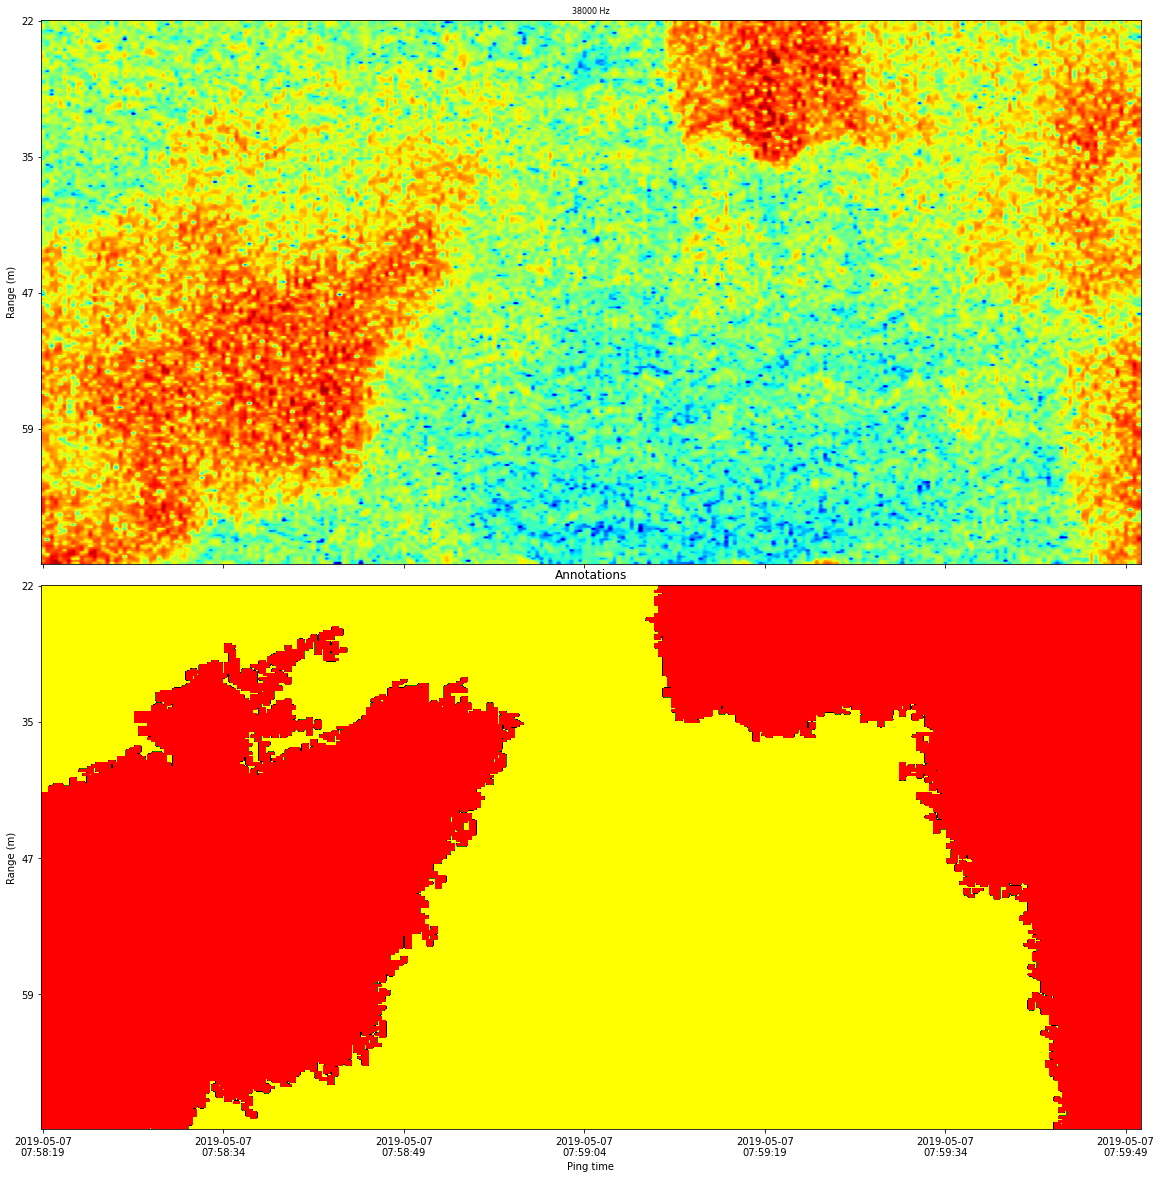

In [276]:
row = 2212
ping_idx = int(coordinates[row, 1]) - 128
range_idx = int(coordinates[row, 2]) - 128
print(samplers_str[coordinates[row, 0]])
plt.figure(figsize=(10,10))
survey.visualize(ping_idx, n_pings=256, range_idx=range_idx, n_range=256, frequencies=[38000])

# Pixel Summary of Patches (500 Background, 5*500 from other classes)

In [277]:
0.01*2000*4000000

80000000.0

In [191]:
extend_pdata = pdata[pdata.sampler != 'Background Sampler'].copy()
extend_pdata_all = pd.DataFrame(np.repeat(extend_pdata.values, 5, axis=0))

#assign column names of original DataFrame to new DataFrame
extend_pdata_all.columns = extend_pdata.columns

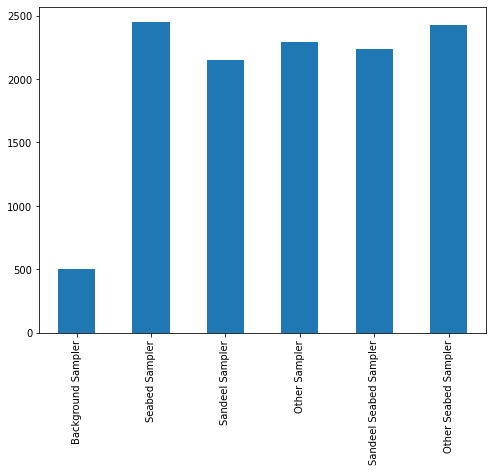

In [223]:
plt.figure(figsize=(8,6))
result.sampler.value_counts(sort=False).plot(kind='bar')
plt.show()

In [221]:
frames = [pdata[pdata.sampler == 'Background Sampler'], extend_pdata_all]
  
result = pd.concat(frames)
print('Number of Patches from each Sampler')
print(result.sampler.value_counts(sort=False))
print('\nPercentage (%) of Patches from each Sampler')
print(100*result.sampler.value_counts(sort=False)/result.sampler.value_counts().sum())

Number of Patches from each Sampler
Background Sampler         500
Seabed Sampler            2450
Sandeel Sampler           2150
Other Sampler             2290
Sandeel Seabed Sampler    2235
Other Seabed Sampler      2425
Name: sampler, dtype: int64

Percentage (%) of Patches from each Sampler
Background Sampler         4.149378
Seabed Sampler            20.331950
Sandeel Sampler           17.842324
Other Sampler             19.004149
Sandeel Seabed Sampler    18.547718
Other Seabed Sampler      20.124481
Name: sampler, dtype: float64


In [195]:
# Multiplying samplers pixel values wih 5 (execpt background)
ot, sd, bg, sm = result.nop_other.sum(), result.nop_sandeel.sum(), result.nop_background.sum(), (result.nop_other.sum()+result.nop_sandeel.sum()+result.nop_background.sum())
print(f'Other = % {(100*ot/sm):.2f}, Sandeel = % {100*sd/sm:.2f}, Background = % {100*bg/sm:.2f}')


Other = % 0.31, Sandeel = % 0.38, Background = % 99.31


In [278]:
80000/26

3076.923076923077

In [ ]:
# Testing visualize function
plt.imshow(survey.get_data_slice(ping_idx, 256, range_idx, 256, frequencies=[38000])[0].T)
plt.show()
plt.imshow(survey.get_label_slice(ping_idx, 256, range_idx, 256).T)
plt.show()